### Jump to: <a id="contents"></a>

**Getting started**
- [import packages](#import)
- [import data](#data)

**Data acquisition**
- [find articles by field](#articles)
- [find hyperlinks](#hyperlinks)

**Networks**
- [build hyperlink network](#link_network)
- [build category network](#cat_network)
- [build field-to-field network](#field_network)
- [calculate network features](#features)
- [degree distribution](#degree)

**Fields**
- [describe fields](#fields)
- [predict field with network features](#prediction)
- [secondary field-to-field network](#secondary)
- [tertiary field-to-field network](#tertiary)

-------------------------

### import packages <a id="import">

[**back**](#contents)

In [2]:
import wikipediaapi

import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import pickle
from tqdm.notebook import tqdm as tqdm
from itertools import combinations, repeat, chain, permutations, product

from functions import *

import gc

In [3]:
sns.set()

In [4]:
matplotlib.rcParams["figure.figsize"] = (15, 15)

-------------------------

### import data <a id="data">

[**back**](#contents)

In [5]:
def get(filename, fileformat="parquet"):

    if fileformat == "parquet":

        return pd.read_parquet(f"output/{filename}.{fileformat}")

    with open(f"output/{filename}.{fileformat}", "rb") as fp:
        return pickle.load(fp)

In [ ]:
articles = get("articles")

In [6]:
nodes = get("nodes")

In [7]:
edges = get("edges")

In [8]:
fields = get("fields")

In [9]:
L_link = build_graph(
    nodes["node"].unique(), edges[["from", "to"]].drop_duplicates().values, False, True
)

Name: 
Type: DiGraph
Number of nodes: 24638
Number of edges: 655873
Average in degree:  26.6204
Average out degree:  26.6204


In [ ]:
field_link_matrix = get("field_link_matrix")

In [ ]:
field_dummies = get("field_dummies")

In [ ]:
field_coeff_matrix = get("field_coeff_matrix")

In [33]:
secondary_edges = get("secondary_edges")

In [41]:
secondary_field_link_matrix = get("secondary_field_link_matrix")

In [ ]:
tertiary_edges = get("tertiary_edges")

------------

### find articles by field <a id="articles"></a>

[**back**](#contents)

**DATA SOURCE**:

last time of data acquisition: March 12, 2021

[**Wikipedia hyperlinks**](https://snap.stanford.edu/data/wiki-topcats.html)

[**Wikipedia-API documentation**](https://pypi.org/project/Wikipedia-API/)

**ACADEMIC FIELDS**:

based on [**Wikipedia's list of academic field**](https://en.wikipedia.org/wiki/List_of_academic_fields)

In [ ]:
fields = pd.concat(
    [
        pd.DataFrame(
            [
                [n.split("\n")[0], n.split("\n")[k]]
                for k in range(1, len(n.split("\n")))
            ],
            columns=["broad_field", "field"],
        )
        for n in open("fields.txt", "r").read().split("\n\n")
    ]
).reset_index(drop=True)

In [ ]:
wiki = wikipediaapi.Wikipedia(
    language="en", extract_format=wikipediaapi.ExtractFormat.WIKI
)

In [ ]:
articles_dict = {
    category: find_category_members(wiki, category)
    for category in tqdm(fields["field"].unique())
}

In [ ]:
articles = fields.merge(
    pd.concat(
        [
            pd.DataFrame([[key, v] for v in values], columns=["field", "article"])
            for key, values in articles_dict.items()
        ]
    ),
    on="field",
)

In [ ]:
articles.to_parquet("output/articles.parquet", index=False)

------------

### find hyperlinks <a id="hyperlinks"></a>

[**back**](#contents)

In [ ]:
edges_dict = {}

for n in tqdm(articles["article"].unique()):

    edges_dict[n] = set(articles["article"]).intersection(find_links(wiki, n))

In [ ]:
all_edges = pd.DataFrame(
    np.concatenate(
        [
            np.array([[key, v] for v in values])
            for key, values in edges_dict.items()
            if len(values) != 0
        ]
    ),
    columns=["from", "to"],
).loc[lambda df: df["from"] != df["to"]]

In [ ]:
all_edges.to_parquet("output/all_edges.parquet", index=False)

--------------

### build hyperlink network <a id="link_network"></a>

[**back**](#contents)

In [ ]:
G_link = build_graph(articles["article"].unique(), all_edges.values, False, True)

In [ ]:
L_link = G_link.subgraph(max(nx.strongly_connected_components(G_link), key=len))

In [ ]:
print(nx.info(L_link))

In [ ]:
edges = (
    pd.DataFrame(list(L_link.edges()), columns=["from", "to"])
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_from", "article": "from"}
        ),
        on="from",
        how="left",
    )
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_to", "article": "to"}
        ),
        on="to",
        how="left",
    )
    .pipe(
        lambda df: df.merge(
            df.groupby(["from", "to"])["field_from"]
            .count()
            .pipe(lambda s: 1 / s)
            .reset_index()
            .rename(columns={"field_from": "weight"}),
            on=["from", "to"],
            how="left",
        )
    )
    .assign(within_field=lambda df: df["field_from"] == df["field_to"])
    .sort_values(by=["from", "to"])
    .reset_index(drop=True)
)

In [ ]:
edges.head(5)

In [ ]:
edges.to_parquet("output/edges.parquet", index=False)

-------------------

### build category network <a id="cat_network"></a>

[**back**](#contents)

In [ ]:
cross_category_edges = (
    pd.Series(
        sum(
            nodes.groupby("node").apply(
                lambda df: [
                    tuple(sorted(c)) for c in combinations(df["field"].values, 2)
                ]
            ),
            [],
        ),
    )
    .value_counts()
    .reset_index()
    .rename(columns={"index": "edge", 0: "n"})
    .assign(
        weight=lambda df: df.apply(
            lambda r: r["n"] / fields.loc[list(r["edge"]), "n_nodes"].min(), axis=1
        )
    )
)

In [ ]:
G_cat = build_graph(
    fields.index.tolist(),
    cross_category_edges.apply(lambda r: (*r["edge"], r["weight"]), axis=1),
    True,
    False,
)

In [ ]:
G_cat_backbone = backbone_extraction(G_cat, 0.25, directed=False)

In [ ]:
highlight_backbone(
    G_cat,
    G_cat_backbone,
    fields.index.tolist(),
    fields["n_nodes_weighted"].to_dict(),
    startangle=-7,
)

-------------------

### build field-to-field network <a id="field_network"></a>

[**back**](#contents)

In [ ]:
G_field = build_graph(
    fields.index.tolist(),
    (field_link_matrix.apply(lambda c: c / c.sum()).unstack().reset_index()).values,
    True,
    True,
)

In [ ]:
G_field_backbone = backbone_extraction(G_field, 0.05)

In [ ]:
draw_backbone(
    G_field_backbone,
    fields.index.tolist(),
    fields["color"].to_dict(),
    node_size=fields["n_nodes_weighted"].to_dict(),
    startangle=-7,
    title="Backbone of cross-field network",
    save=True,
)

--------------

### calculate network features <a id="features"></a>

[**back**](#contents)

In [ ]:
nodes = (
    articles.drop("broad_field", axis=1)
    .loc[articles["article"].isin(set(L_link.nodes()))]
    .reset_index(drop=True)
    .rename(columns={"article": "node"})
    .pipe(
        lambda df: df.merge(
            df[["node"]]
            .drop_duplicates()
            .assign(
                in_degree=lambda df: df["node"].apply(lambda n: L_link.in_degree(n)),
                out_degree=lambda df: df["node"].apply(lambda n: L_link.out_degree(n)),
                neighbor_conn=lambda df: df["node"].apply(
                    neighbor_connectivity, args=(L_link, False, True)
                ),
                clustering=lambda df: df["node"].apply(clustering, graph=L_link),
            ),
            on="node",
        )
        .merge(
            df.merge(
                edges.loc[edges["within_field"]],
                left_on=["node", "field"],
                right_on=["to", "field_to"],
            )
            .drop(["to", "field_from", "field_to"], axis=1)
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "within_field_in_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["from", "field_from"])
            .drop(["from", "field_from", "field_to"], axis=1)
            .loc[lambda df: df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "within_field_out_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["to", "field_to"])
            .drop(["to", "field_from", "field_to"], axis=1)
            .loc[lambda df: ~df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "cross_field_in_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["from", "field_from"])
            .drop(["from", "field_from", "field_to"], axis=1)
            .loc[lambda df: ~df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "cross_field_out_degree"}),
            on=["node", "field"],
            how="left",
        )
        .fillna(0)
        .merge(
            pd.DataFrame.from_dict(
                {n: len(grow_canopy(n, L_link)) for n in df["node"].unique()},
                orient="index",
                columns=["canopy"],
            )
            .reset_index()
            .rename(columns={"index": "node"}),
            on="node",
        )
    )
    .merge(
        pd.DataFrame.from_dict(
            nx.betweenness_centrality(L_link),
            orient="index",
            columns=["betwenness"],
        )
        .merge(
            pd.DataFrame.from_dict(
                nx.closeness_centrality(L_link),
                orient="index",
                columns=["closeness"],
            ),
            left_index=True,
            right_index=True,
        )
        .merge(
            pd.DataFrame.from_dict(
                nx.closeness_centrality(L_link.reverse()),
                orient="index",
                columns=["closeness_out"],
            ),
            left_index=True,
            right_index=True,
        )
        .reset_index()
        .rename(columns={"index": "node"}),
        on="node",
        how="left",
    )
)

In [ ]:
nodes.head(5)

In [ ]:
nodes.to_parquet("output/nodes.parquet", index=False)

-------------

### degree distribution <a id="degree"></a>

[**back**](#contents)

In [ ]:
degree_dist(
    nodes.drop_duplicates("node")[["in_degree", "out_degree"]].values.T,
    "Hyperlink degree distribution",
    labels=["in degree", "out degree"],
    save=True,
)

In [ ]:
degree_dist(
    nodes.drop_duplicates("node")[
        ["within_field_in_degree", "within_field_out_degree"]
    ].values.T,
    "Within-field hyperlink degree distribution",
    labels=["in degree", "out degree"],
    save=True,
)

In [ ]:
degree_dist(
    nodes.drop_duplicates("node")[
        ["cross_field_in_degree", "cross_field_out_degree"]
    ].values.T,
    "Cross-field hyperlink degree distribution",
    labels=["in degree", "out degree"],
    save=True,
)

In [ ]:
nodes[[c for c in nodes.columns if "degree" in c]].corr().abs().pipe(
    lambda df: corr_heatmap(
        df,
        "Correlations between different types of degrees",
        figsize=(15, 6),
        annot=df.round(2),
        xrotation=10,
        cbar_pad=0.3,
    )
)

-------------

### describe fields <a id="fields"></a>

[**back**](#contents)

In [ ]:
field_link_matrix = (
    edges[["field_from", "field_to", "weight"]]
    .pivot_table(columns="field_from", index="field_to", values="weight", aggfunc="sum")
    .fillna(0)
)

In [ ]:
field_link_matrix.to_parquet("output/field_link_matrix.parquet")

In [ ]:
fields = (
    (
        (
            fields.merge(
                nodes.groupby("field")["node"]
                .nunique()
                .reset_index()
                .rename(columns={"node": "n_nodes"}),
                on="field",
                how="right",
            )
            .merge(
                nodes.groupby("node")["field"]
                .nunique()
                .apply(lambda s: 1 / s)
                .reset_index()
                .rename(columns={"field": "n_nodes_weighted"})
                .merge(nodes[["node", "field"]], on="node", how="right")
                .groupby("field")["n_nodes_weighted"]
                .sum()
                .reset_index(),
                on="field",
                how="left",
            )
            .assign(
                rel_size=lambda df: df["n_nodes_weighted"].pipe(lambda s: s / s.sum())
            )
            .fillna(0)
        )
        .assign(
            ext_citations=lambda df: df["field"].apply(
                lambda f: (
                    field_link_matrix.loc[f, :].sum() - field_link_matrix.loc[f, f]
                )
            )
        )
        .pipe(
            lambda df: df.assign(
                rel_ext_use=lambda df: df["ext_citations"]
                / field_link_matrix.sum().sum()
                * (1 - df["rel_size"])
                / df["rel_size"],
                ext_cit_avg=lambda df: df["ext_citations"] / df["n_nodes_weighted"],
                imp_exp_ratio=lambda df: df["ext_citations"]
                / df["field"].apply(
                    lambda f: (field_link_matrix[f].sum() - field_link_matrix.loc[f, f])
                ),
            )
        )
    )
    .merge(
        field_link_matrix.sum(axis=1)
        .reset_index()
        .rename(
            columns={
                "field_to": "field",
                0: "in_degree",
            }
        ),
        on="field",
        how="left",
    )
    .merge(
        field_link_matrix.sum(axis=0)
        .reset_index()
        .rename(
            columns={
                "index": "field",
                0: "out_degree",
            }
        ),
        on="field",
        how="left",
    )
    .merge(
        field_link_matrix.apply(lambda c: c / c.sum())
        .apply(lambda r: gini(r), axis=1)
        .reset_index()
        .rename(columns={"field_to": "field", 0: "gini"}),
        on="field",
    )
    .set_index("field")
    .sort_values(by=["broad_field", "rel_size"])
).pipe(
    lambda df: df.assign(
        color=magma_as_hex(df.shape[0]),
        color_b=df["broad_field"].apply(
            lambda s: {
                f: magma_as_hex(df["broad_field"].nunique())[n]
                for n, f in enumerate(df["broad_field"].sort_values().unique())
            }[s]
        ),
    )
)

In [ ]:
fields.head(5)

In [ ]:
fields.to_parquet("output/fields.parquet")

In [ ]:
title = "Relative sizes of fields"

fig, ax = plt.subplots(figsize=(15, 15))

wedges, texts = ax.pie(
    fields["rel_size"].values,
    colors=fields["color_b"],
    wedgeprops={"width": 0.3, "linewidth": 3},
    startangle=-93,
)

for i, w in enumerate(wedges):

    ang = (w.theta2 - w.theta1) / 2.0 + w.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    ax.annotate(
        "{} ({}%)".format(
            fields.index[i],
            round(100 * fields["rel_size"].values[i], 2),
        ),
        xy=(x, y),
        xytext=(1.2 * np.sign(x), 1.4 * y),
        horizontalalignment="left" if np.sign(x) == 1 else "right",
        font_properties=font_props["label"],
        fontsize=18,
        arrowprops={
            "color": "black",
            "arrowstyle": "-",
            "connectionstyle": f"angle,angleA=0,angleB={ang}",
        },
    )

plt.title(title, fontproperties=font_props["title"], pad=-300)

fields.reset_index().groupby("broad_field")[["rel_size", "color_b"]].agg(
    {"rel_size": "sum", "color_b": "max"}
).sort_values(by="rel_size").pipe(
    lambda df: plt.legend(
        handles=[
            Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=20)
            for c in df["color_b"]
        ],
        labels=df.apply(
            lambda r: "{} ({} %)".format(r.name, round(r["rel_size"] * 100, 2)), axis=1
        ).values.tolist(),
        loc="center",
        prop=font_props["label"],
        frameon=False,
    )
)

plt.savefig(
    "figs/{}.png".format("_".join(title.lower().split(" "))), bbox_inches="tight"
)

In [ ]:
ranking_dict = {
    "ext_citations": "number of external citations",
    "rel_ext_use": "relative external use",
    "ext_cit_avg": "external citation average",
    "imp_exp_ratio": "import-export ratio",
}

In [ ]:
fig, axes_arr = plt.subplots(2, 2, figsize=(50, 40))
fig.tight_layout(h_pad=10, w_pad=30)
axes = axes_arr.flatten()

for i, attr in enumerate(ranking_dict.keys()):

    sorted_fields = fields.sort_values(by=attr)
    y_coords = np.linspace(0, 1, sorted_fields.shape[0])

    axes[i].barh(
        y_coords,
        sorted_fields[attr],
        color=sorted_fields["color_b"],
        linewidth=3,
        left=0,
        height=0.025,
    )

    if attr == "imp_exp_ratio":
        axes[i].set_xlim(0.5, 1.3)

    for j, y in enumerate(y_coords):

        xlow, xhigh = axes[i].get_xlim()

        axes[i].text(
            xlow - (xhigh - xlow) * 0.2,
            y - 0.008,
            sorted_fields.index[j],
            font_properties=font_props["label"],
        )

    for label in axes[i].get_xticklabels():
        label.set_fontproperties(font_props["ticks"])

    axes[i].set_yticks([])
    axes[i].set_ylim(-0.025, 1.025)
    axes[i].set_title(
        f"Ranking by: {ranking_dict[attr]}", font_properties=font_props["title"], pad=20
    )

    if i == 0:

        legend = (
            sorted_fields.reset_index()
            .groupby("broad_field")[["rel_size", "color_b"]]
            .agg({"rel_size": "sum", "color_b": "max"})
            .sort_values(by="rel_size")
            .pipe(
                lambda df: axes[i].legend(
                    handles=[
                        Patch(facecolor=c, edgecolor="white", linewidth=3)
                        for c in df["color_b"]
                    ],
                    labels=df.index.tolist(),
                    loc="center",
                    facecolor=None,
                    edgecolor="white",
                    fancybox=False,
                    prop=font_props["label"],
                )
            )
        )

        legend.get_frame().set_linewidth(3)

plt.savefig("figs/rankings.png", bbox_inches="tight")

In [ ]:
field_link_matrix.apply(lambda c: c / c.sum()).pipe(
    lambda df: corr_heatmap(
        df,
        "Distribution of hyperlinks between fields",
        figsize=(20, 20),
        annot=(df * 100).round(2),
        vmin=0.05,
        mask=df < 0.05,
        enhance=True,
        xlabel="from:",
        ylabel="to:",
        cbar_pad=0.2,
        save=True,
    )
)

In [ ]:
pd.DataFrame(G_field_backbone.edges(data=True)).rename(
    columns={i: n for i, n in enumerate(["field_from", "field_to", "weight"])}
).assign(weight=lambda df: df["weight"].apply(lambda w: w["weight"])).pivot_table(
    index="field_to", columns="field_from", values="weight", aggfunc="sum"
).pipe(
    lambda df: corr_heatmap(
        df,
        "Distribution of hyperlinks between fields (backbone)",
        figsize=(20, 20),
        annot=(df * 100).round(2),
        enhance=True,
        xlabel="from:",
        ylabel="to:",
        cbar_pad=0.2,
        vmin=0.05,
        save=True,
    )
)

----------

### predict field with network features <a id="prediction">

[**back**](#contents)

In [ ]:
field_dummies = nodes.pivot_table(
    index="node", columns="field", values="in_degree", aggfunc="count"
).fillna(0)

In [ ]:
field_dummies.to_parquet("output/field_dummies.parquet")

In [ ]:
field_dummies.corr().pipe(
    lambda df: corr_heatmap(
        df,
        "Correlation matrix of field dummies",
        figsize=(20, 20),
        annot=df.round(2),
        mask=df < 0.05,
        enhance=True,
        cbar_pad=0.2,
    )
)

In [ ]:
X = (
    (
        nodes.drop_duplicates(["node", "field"])
        .groupby("node")
        .mean()
        .assign(
            p_cross_field_in=lambda df: df["cross_field_in_degree"] / df["in_degree"],
            p_cross_field_out=lambda df: df["cross_field_out_degree"]
            / df["out_degree"],
        )
        .fillna(0)
    )[
        [
            "out_degree",
            "neighbor_conn",
            "clustering",
            "betwenness",
            "closeness",
            "closeness_out",
            "p_cross_field_in",
            "p_cross_field_out",
        ]
    ]
    .pipe(
        lambda df: pd.DataFrame(
            StandardScaler().fit_transform(df), columns=df.columns, index=df.index
        )
    )
    .assign(const=1)
)

In [ ]:
X.drop("const", axis=1).corr().abs().pipe(
    lambda df: corr_heatmap(
        df,
        "Correlation matrix of exogenous variables",
        annot=df,
        mask=df < 0.05,
        cbar_pad=0.12,
        xrotation=20,
        save=True,
    )
)

In [ ]:
all_results = {
    f: logit_model(
        X,
        field_dummies[f],
    )
    for f in field_dummies.columns
}

In [ ]:
field_coeff_matrix = (
    (
        pd.concat(
            [
                pd.DataFrame(
                    [
                        series.rename(index={i: c for i, c in enumerate(X.columns)})
                        for series in [
                            pd.Series(v["model"].p_values).rename("p"),
                            pd.Series(v["model"].coef_[0]).rename("coeffs"),
                        ]
                    ]
                ).T.assign(field=k)
                for k, v in all_results.items()
            ]
        )
        .drop("const")
        .assign(
            sign_coeffs=lambda df: (
                df["coeffs"] * (0.01 > df["p"]).astype(int)
            ).replace(0, np.nan)
        )
    )
    .reset_index()
    .rename(columns={"index": "var"})
    .pivot_table(index="field", columns="var", values="sign_coeffs", aggfunc="max")
)

In [ ]:
reg_metrics = {k: v["metrics"] for k, v in all_results.items()}

In [ ]:
field_coeff_matrix.to_parquet("output/field_coeff_matrix.parquet")

In [ ]:
with open("output/reg_metrics.pickle", "wb") as fp:
    pickle.dump(reg_metrics, fp)

In [ ]:
field_coeff_matrix[field_coeff_matrix.isna().sum().sort_values().index.tolist()].pipe(
    lambda df: df.sort_values(by=df.columns.tolist(), ascending=False)
).pipe(
    lambda df: corr_heatmap(
        df,
        "Regression coefficients by field and variable",
        annot=df.round(2),
        vmin=df.round(1).min().min(),
        vmax=df.round(1).max().max(),
        mask=df.isna(),
        xrotation=20,
        cbar_nticks=6,
        cbar_pad=0.1,
        save=True
    )
)

In [ ]:
plot_reg_metrics(
    reg_metrics, "False positive rate", "True positive rate", "ROC curve", save=True
)

In [ ]:
plot_reg_metrics(
    reg_metrics,
    "Precision",
    "Recall",
    "Precision-recall curve",
    to_plot="p-r",
    save=True,
)

--------

### secondary field-to-field network <a id="secondary">

#### [back](#contents)

In [ ]:
secondary_edges = (
    pd.DataFrame(
        (nx.adjacency_matrix(L_link) ** 2).toarray(),
        index=list(L_link.nodes()),
        columns=list(L_link.nodes()),
    )
    .pipe(
        lambda A: pd.concat(
            [
                A.iloc[i : i + 500, :].unstack().loc[lambda s: s > 0]
                for i in range(0, A.shape[0], 500)
            ]
        )
        .reset_index()
        .rename(columns={"level_0": "from", "level_1": "to", 0: "weight"})
    )
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_from", "article": "from"}
        ),
        on="from",
        how="left",
    )
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_to", "article": "to"}
        ),
        on="to",
        how="left",
    )
    .pipe(
        lambda df: df.drop("weight", axis=1).merge(
            df.groupby(["from", "to"])["weight"]
            .agg(["min", "count"])
            .assign(weight=lambda df2: df2["min"] / df2["count"])
            .reset_index()
            .drop(["min", "count"], axis=1),
            on=["from", "to"],
        )
    )
)

In [ ]:
secondary_edges.to_parquet("output/secondary_edges.parquet")

In [ ]:
secondary_field_link_matrix = (
    secondary_edges[["field_from", "field_to", "weight"]]
    .pivot_table(columns="field_from", index="field_to", values="weight", aggfunc="sum")
    .fillna(0)
)

In [ ]:
secondary_field_link_matrix.to_parquet("output/secondary_field_link_matrix.parquet")

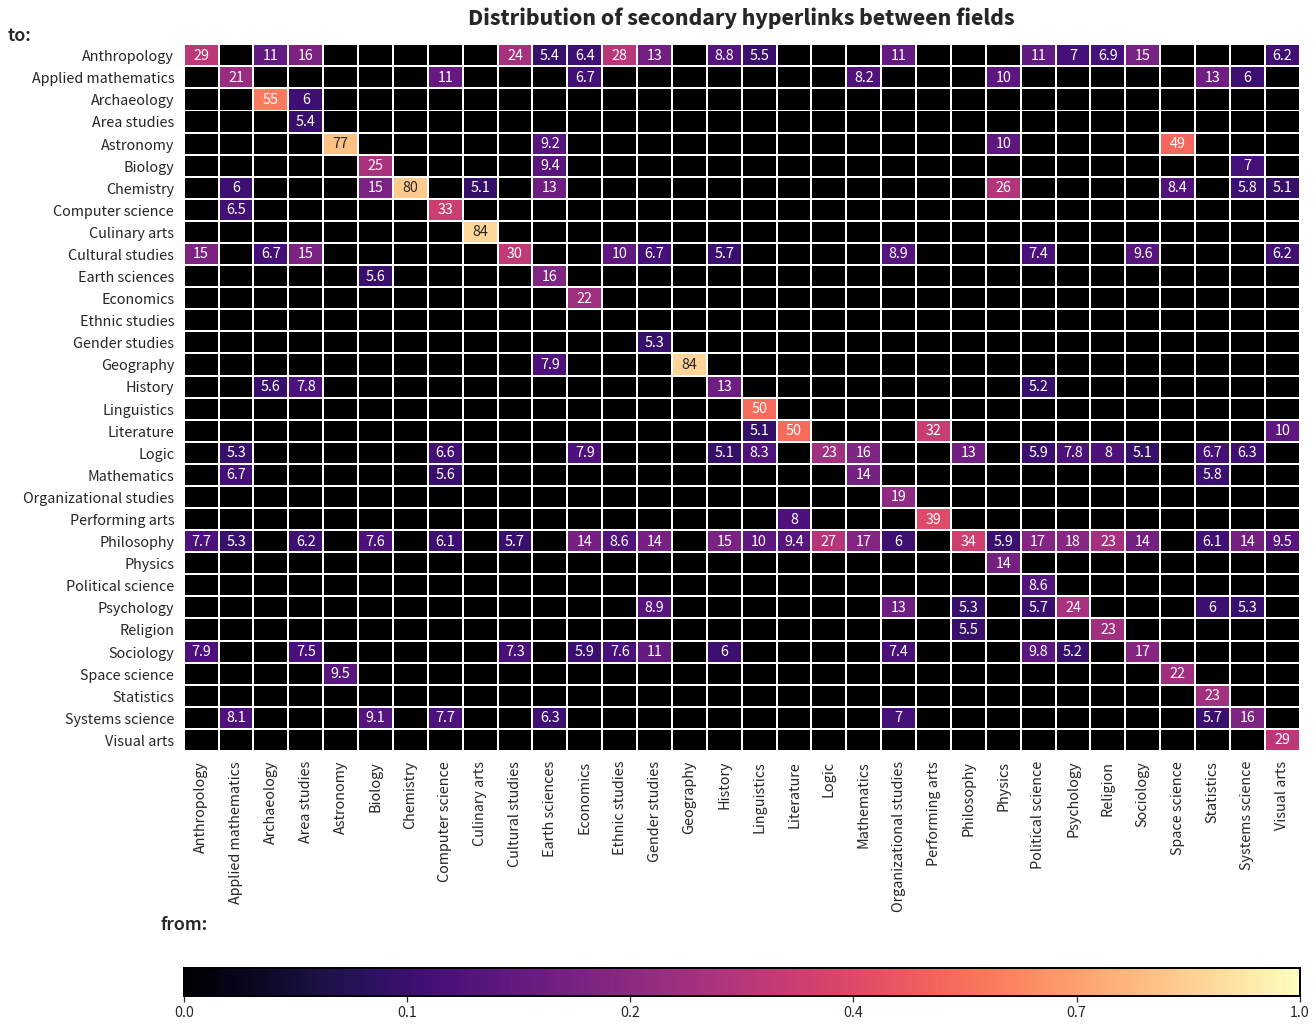

In [42]:
secondary_field_link_matrix.apply(lambda c: c / c.sum()).pipe(
    lambda df: corr_heatmap(
        df,
        "Distribution of secondary hyperlinks between fields",
        figsize=(20, 20),
        annot=(df * 100).round(2),
        vmin=0.05,
        mask=df < 0.05,
        enhance=True,
        xlabel="from:",
        ylabel="to:",
        cbar_pad=0.2,
        save=True,
    )
)

In [43]:
G_field_secondary = build_graph(
    fields.index.tolist(),
    (
        secondary_field_link_matrix.apply(lambda c: c / c.sum()).unstack().reset_index()
    ).values,
    True,
    True,
)

Name: 
Type: DiGraph
Number of nodes: 32
Number of edges: 1024
Average in degree:  32.0000
Average out degree:  32.0000


In [44]:
G_field_secondary_backbone = backbone_extraction(G_field_secondary, 0.05)

Name: 
Type: DiGraph
Number of nodes: 32
Number of edges: 82
Average in degree:   2.5625
Average out degree:   2.5625


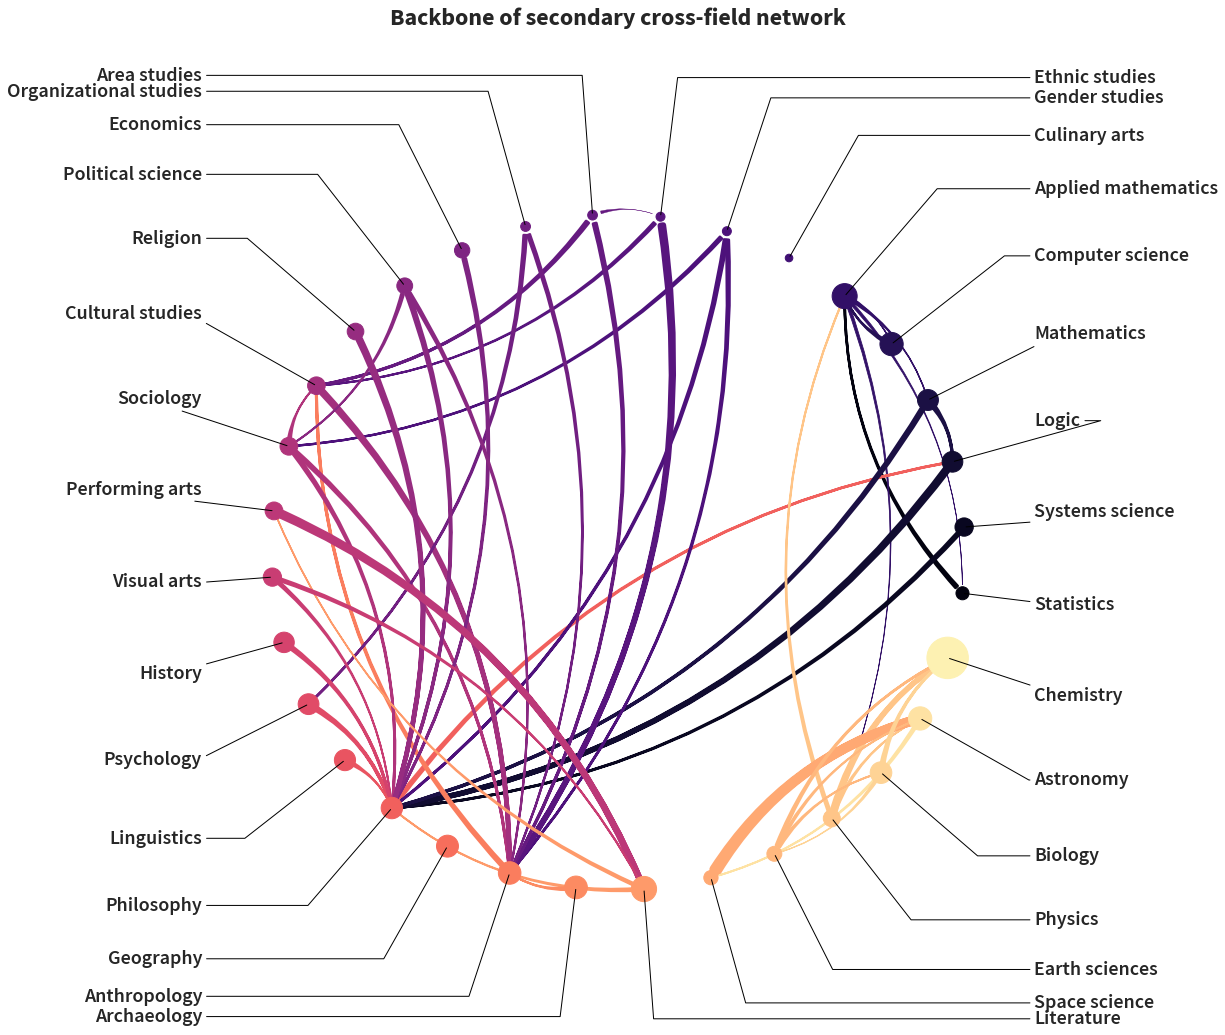

In [45]:
draw_backbone(
    G_field_secondary_backbone,
    fields.index.tolist(),
    fields["color"].to_dict(),
    node_size=fields["n_nodes_weighted"].to_dict(),
    startangle=-7,
    title="Backbone of secondary cross-field network",
    save=True,
)

----------

### tertiary field-to-field network <a id="tertiary">

#### [back](#contents)

In [10]:
adj_sparse = nx.adjacency_matrix(L_link) ** 3

In [11]:
npedges = np.zeros((adj_sparse.data.shape[0], 3), dtype=int)

In [12]:
for i, rowstart in enumerate(adj_sparse.indptr[:-1]):
    rowend = adj_sparse.indptr[i + 1]
    npedges[rowstart:rowend, 0] = i
    npedges[rowstart:rowend, 1] = adj_sparse.indices[rowstart:rowend]
    npedges[rowstart:rowend, 2] = adj_sparse.data[rowstart:rowend]

In [13]:
del adj_sparse
gc.collect()

60

In [14]:
tertiary_edges = pd.DataFrame(npedges, columns=["from", "to", "weight"])

In [ ]:
tertiary_edges.to_parquet("output/tertiary_edges.parquet")

In [15]:
index_df = (
    pd.DataFrame(
        [[i, n] for i, n in enumerate(L_link.nodes())], columns=["index", "node"]
    )
    .merge(nodes[["node", "field"]], on="node")
    .merge(
        fields.assign(field_index=range(fields.shape[0]))[
            ["field_index"]
        ].reset_index(),
        on="field",
    )
    .assign(fieldcount=lambda df: df.groupby("index")["field_index"].transform("nunique").values)
)

In [16]:
(_, singlefield), (__, multifield) = index_df.groupby(index_df["fieldcount"] > 1)

In [17]:
indsets = {f: gdf["index"].pipe(set) for f, gdf in singlefield.groupby("field")}

In [18]:
slinks = []

In [19]:
for gid, inds in tqdm(indsets.items()):
    targs = tertiary_edges.loc[lambda df: df["from"].isin(inds), ["to", "weight"]]
    for gid2, inds2 in indsets.items():
        slinks.append(
            {
                "field_from": gid,
                "field_to": gid2,
                "weight": targs.loc[lambda df: df["to"].isin(inds2), "weight"].sum(),
            }
        )

  0%|          | 0/32 [00:00<?, ?it/s]

In [20]:
tertiary_field_edges = pd.DataFrame(slinks).set_index(["field_from", "field_to"])

In [21]:
multi_inds = multifield["index"].pipe(set)

In [23]:
multi_edges = tertiary_edges.loc[
    lambda df: df["from"].isin(multi_inds) | df["to"].isin(multi_inds), :
]

In [24]:
batchsize = 100_000

In [25]:
for i in tqdm(range(0, multi_edges.shape[0], batchsize)):
    batch_links = (
        multi_edges.iloc[i : (i + batchsize), :]
        .merge(index_df[["index", "field"]], left_on="from", right_on="index")
        .drop("index", axis=1)
        .rename(columns={"field": "field_from"})
        .merge(index_df[["index", "field"]], left_on="to", right_on="index")
        .drop("index", axis=1)
        .rename(columns={"field": "field_to"})
        .assign(
            weight=lambda df: df["weight"]
            / df.groupby(["from", "to"])["weight"].transform("count")
        )
        .drop(["from", "to"], axis=1)
        .groupby(["field_from", "field_to"])
        .sum()
    )
    ind_union = tertiary_field_edges.index.union(batch_links.index)
    tertiary_field_edges = tertiary_field_edges.reindex(ind_union).fillna(
        0
    ) + batch_links.reindex(ind_union).fillna(0)

  0%|          | 0/360 [00:00<?, ?it/s]

In [26]:
tertiary_field_edges.to_parquet("output/tertiary_field_edges.parquet")

In [27]:
tertiary_field_link_matrix = tertiary_field_edges.reset_index().pivot_table(
    index="field_from", columns="field_to", values="weight"
)

In [28]:
tertiary_field_link_matrix.to_parquet("output/tertiary_field_link_matrix.parquet")

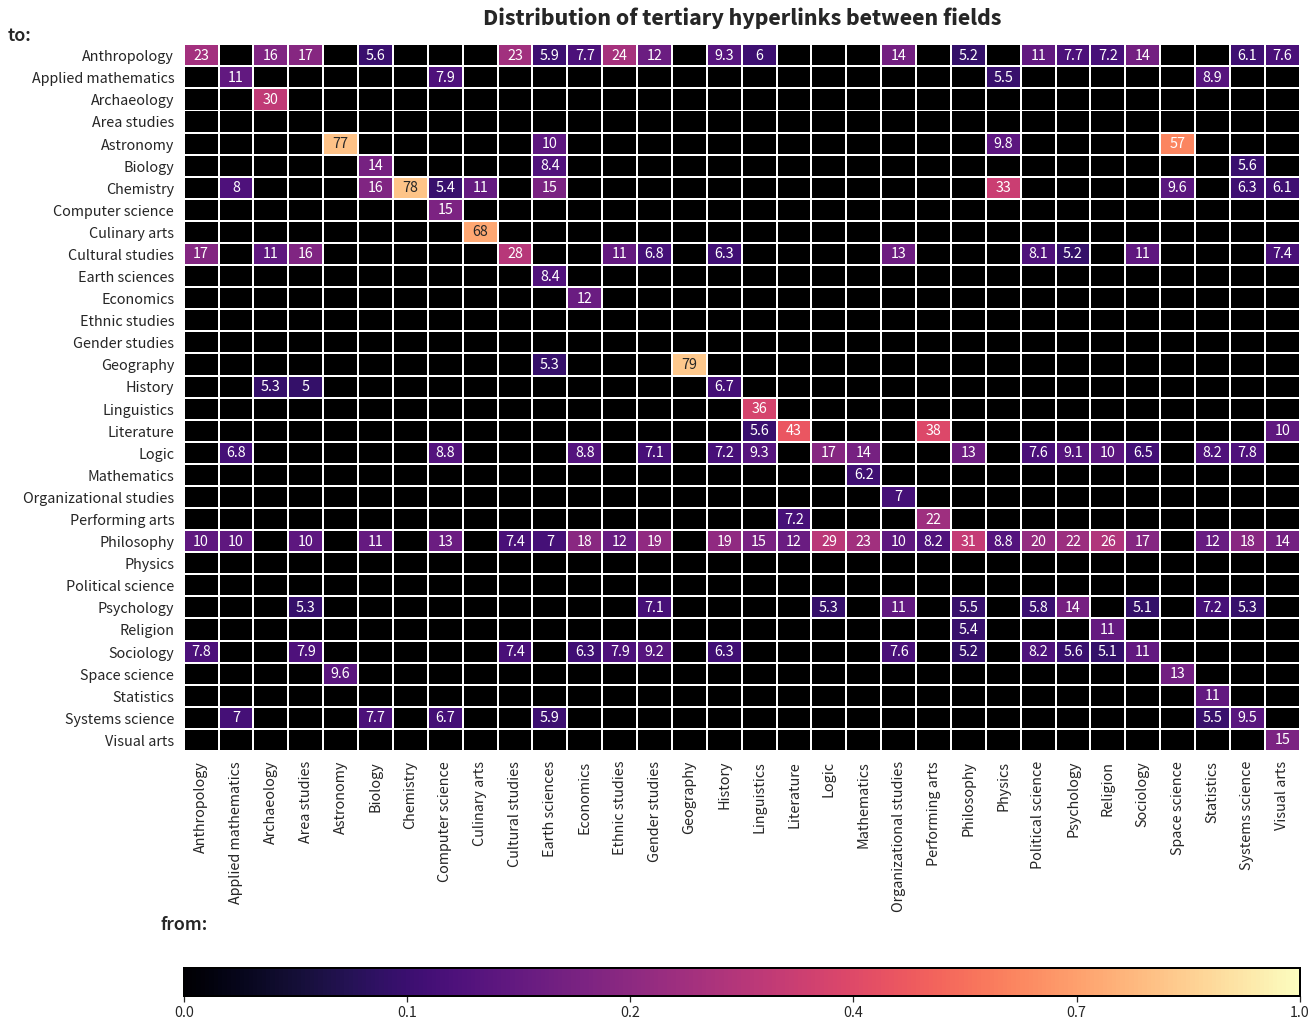

In [29]:
tertiary_field_link_matrix.apply(lambda c: c / c.sum()).pipe(
    lambda df: corr_heatmap(
        df,
        "Distribution of tertiary hyperlinks between fields",
        figsize=(20, 20),
        annot=(df * 100).round(2),
        vmin=0.05,
        mask=df < 0.05,
        enhance=True,
        xlabel="from:",
        ylabel="to:",
        cbar_pad=0.2,
        save=True,
    )
)

In [30]:
G_field_tertiary = build_graph(
    fields.index.tolist(),
    (
        tertiary_field_link_matrix.apply(lambda c: c / c.sum()).unstack().reset_index()
    ).values,
    True,
    True,
)

Name: 
Type: DiGraph
Number of nodes: 32
Number of edges: 1024
Average in degree:  32.0000
Average out degree:  32.0000


In [31]:
G_field_tertiary_backbone = backbone_extraction(G_field_tertiary, 0.05)

Name: 
Type: DiGraph
Number of nodes: 32
Number of edges: 90
Average in degree:   2.8125
Average out degree:   2.8125


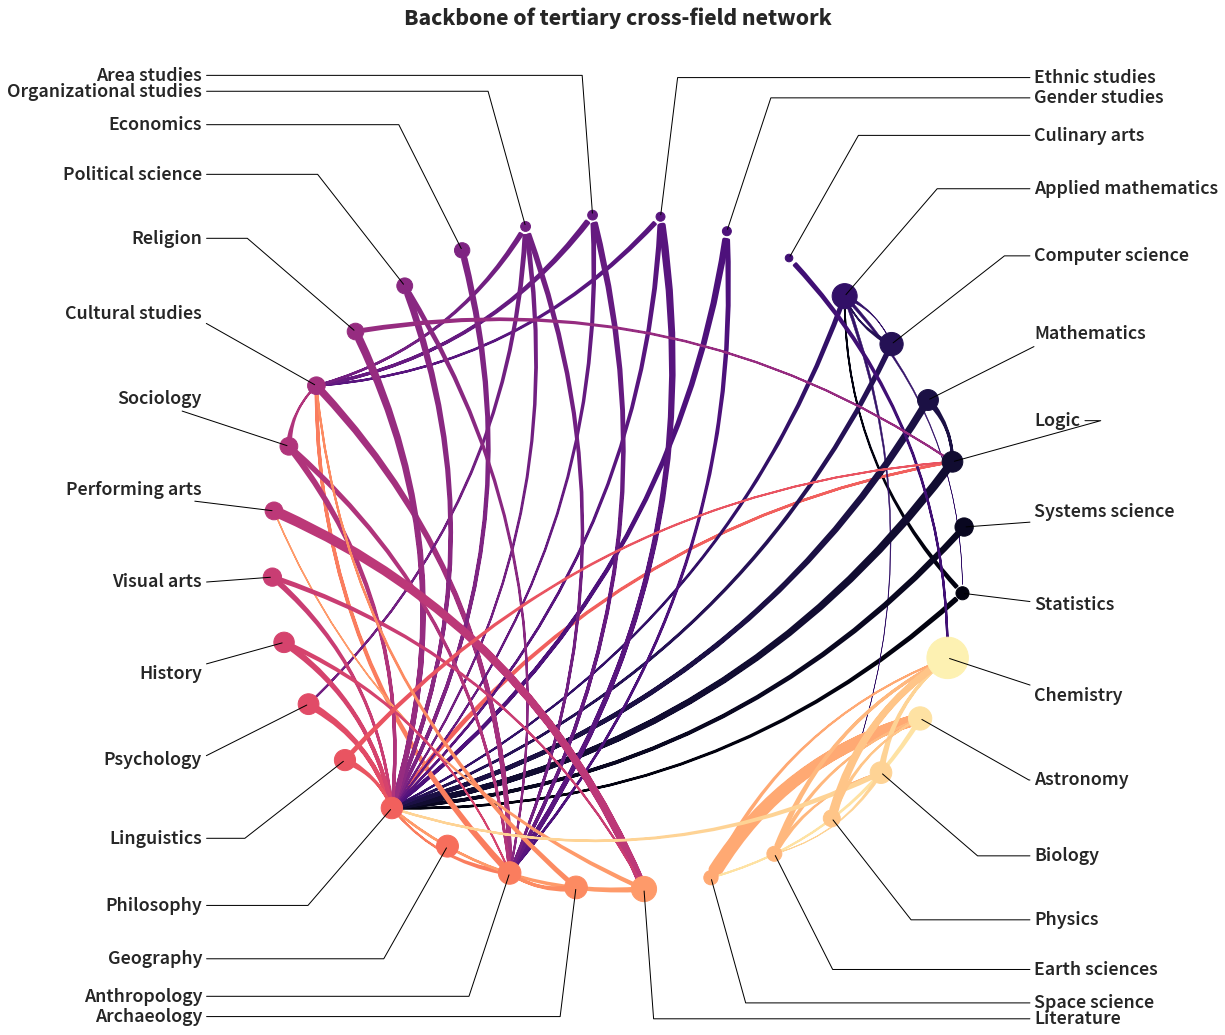

In [32]:
draw_backbone(
    G_field_tertiary_backbone,
    fields.index.tolist(),
    fields["color"].to_dict(),
    node_size=fields["n_nodes_weighted"].to_dict(),
    startangle=-7,
    title="Backbone of tertiary cross-field network",
    save=True,
)